# 신경망을 이용한 1차식의 계수 추정

1. ax+by+c=0 의 1차식을 이용해 학습용 데이터를 생성한다.

   * 해당 직선위에 있는 데이터 
    
   * 노이즈를 섞은 데이터 
    
위의 두 경우로 데이터를 생성하여 학습시 사용해 볼것인데 우선 첫번째 데이터만 사용하여 제대로 학습이 되는지 확인해볼 것이다. 데이터를 생성한 후, 4:1 비율로 train data와 test data로 나누는 과정도 필요하다.

    
2. 3계층 신경망을 생성한다.

(x,y) 좌표를 입력값으로 사용 할것이므로 input의 크기는 2,  a,b,c 계수를 추정할 것이므로 ouput의 크기는 3이다. 은닉층의 뉴런의 개수는 잠시후에 이야기 하겠다.
Affine 계층에 hyper tangent를 활성화 함수로 사용한다. 이는 ReLu나 Sigmoid를 사용하게 되면 추론할 수 있는 범위에 제한이 생기기 때문이다. (ReLu와 Sigmoid의 경우 음수를 통과시키지 않는다.)

![nonlinear activation function](https://www.researchgate.net/profile/Vivienne-Sze/publication/315667264/figure/fig3/AS:669951052496900@1536740186369/Various-forms-of-non-linear-activation-functions-Figure-adopted-from-Caffe-Tutorial.png)

<br>
3계층 신경망을 생성할 것이고, 각층의 뉴런의 개수는 두가지 경우를 시험해 보겠다.

   * 2 -> 2 2 3 -> 3 
    
   * 2 -> 5 10 3 -> 3

출력층에서도 softmax를 사용하지는 않는다. softmax사용시 확률도 바뀌는데 이번에 우리가 구하고자 하는 것은 각 레이블에 대한 추론이 아니라 a,b,c 값 그 자체이다. loss함수는 필요한데 직선과의 거리를 재는 것은 2가지로 가능하다. y축을 기준으로 하는 것과 점과 직선사이 거리를 기준으로 하는 것이다. 우선은 계산이 쉬운 y축 기준 거리를 사용해 볼 것이다.


3. 앞서 생성한 데이터를 이용하여 신경망을 학습한다.

오차 역전파 방식을 이용한다. 이를 위해서는 앞서 신경망을 생성할때 각 계층에 forward뿐 아니라 backward도 구현해야 한다. *loss function만 사용할 때 역전파시 output이 어떻게 되는지 계산 해보아야 함. hyper-tangent의 역전파도 계산 필요*
<br>



In [1]:
import numpy as np
from matplotlib import pyplot as plt

### 계수 정하기 및 데이터 생성

In [60]:
np.random.seed(1)        # 생성되는 데이터를 동일하게 유지

a, b, c = -0.7 , 0.5 , 0.9
answer = [a, b, c]
# ax + by + c = 0
# y = b(- c - a*x)

In [3]:
x = np.random.randn(10000) # 난수 생성
x_data = x       
y_data = (- c - a * x_data)/b

In [4]:
noise = np.random.randn(10000)
y_data += noise

In [5]:
# train / test 분리 - 4 : 1 로 나눔
# x, y 모두 input 으로 t는 [a,b,c]이다.
test_x = x_data[:2000]
test_y = y_data[:2000]
train_x = x_data[2000:]
train_y = y_data[2000:]

x_train = np.stack((train_x, train_y),axis=1)
x_test = np.stack((test_x,test_y),axis=1)

t_train = [answer]*(len(x)-2000)
t_test = [answer]*2000

t_train= np.array(t_train)
t_test= np.array(t_test)

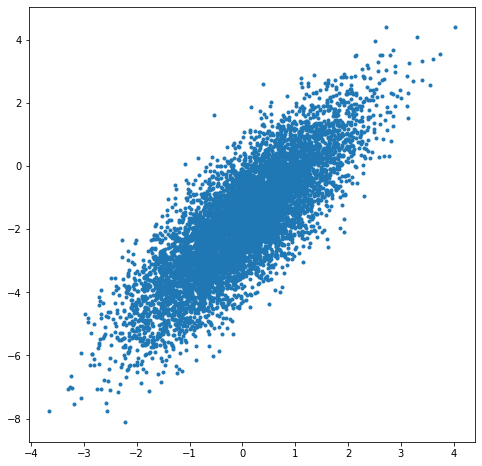

In [6]:
# 데이터 분포 확인,
plt.figure(figsize=(8,8))
plt.plot(x_train[:,0],x_train[:,1],'.')

### 망에 사용할 함수 생성

In [7]:
class hypertangent:
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        self.out = np.tanh(x)
        
        return self.out
    
    def backward(self, dout):
        dx = dout * (1 - self.out*self.out)
        
        return dx

In [47]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.X = None
        
        self.dW = None
        self.db = None
        
    def forward(self, X):
        self.X = X
        if len(self.W)==1:
            out = self.X *self.W + self.b
        else : out = np.dot(self.X, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        #dX = np.dot(dout,self.W.T)             # dX와 X의 형상은 같아야 한다.
        dout = dout[0]
        self.dW = np.dot(self.X.T, dout)        # np.dot은 행렬순서에 따라 값이 달라질 수 있다.
        self.db = np.sum(dout, axis=0)          # 편향이 더해질때 각각의 데이터에 더해졌으므로 역전파시 따로 모으기 위해서는 세로로 모아야함.
        
        #return dX

In [9]:
# 오차 제곱 합? p112

def sum_squares_error(y,t):
    return 0.5*np.sum((y-t)**2)/y.shape[0]

In [10]:
# output layer 만들기 - loss fucntion 만 이용 

class Loss:
    def __init__(self):
        self.t = None
        self.y= None
        self.loss = None
        #  필요한 매개변수?
        
    def forward(self, x, t):
        # x가 신경망의 추론 결과이고, t는 정답레이블이다.
        self.t = t
        self.y = x
        self.loss = sum_squares_error(x, self.t)
        
        return self.loss
        
    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        dx = ( self.y - self.t ) / batch_size
        
        return dx
    

### 신경망 만들기

In [12]:
from collections import OrderedDict
from scratch.common.gradient import numerical_gradient

class ThreeLayerNet:
    def __init__(self, i, h1, h2, o, weight_init_std=0.1):
        
        # 각층에서 사용할 매개변수를 초기화 
        # weight_init_std는 rand를 조절하는 역할을 함.
        self.params={}
        
#         self.params['W1']= np.random.randn(i,h1) * weight_init_std        
#         self.params['W2']= np.random.randn(h1,h2) * weight_init_std
#         self.params['W3']= np.random.randn(h2,o) * weight_init_std

        self.params['W1']= np.random.randn(i,h1) / np.sqrt(i)      
        self.params['W2']= np.random.randn(h1,h2) /np.sqrt(h1)
        self.params['W3']= np.random.randn(h2,o) /np.sqrt(h2)
        
        self.params['b1']= np.zeros(h1)
        self.params['b2']= np.zeros(h2)
        self.params['b3']= np.zeros(o)
        
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['tanh1'] = hypertangent()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['tanh2'] = hypertangent()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['tanh3'] = hypertangent()
        self.lastLayer = Loss() # predict와 loss 계산을 분리 하기 위해
        
        # 활성화 값을 저장할 장소
        self.activation={}
        
        
    # 각 계층을 forward이동     
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
            if isinstance(layer,hypertangent):
                self.activation[layer]=x
            
        return x # (label 종류, )
        
        
    def loss(self, x, t):
        y = self.predict(x)
        
        # 신경망의 예상값 y 와 정답 t 비교
        return self.lastLayer.forward(y,t)
    
    
    def accuracy(self, x, t):
        # 추론 결과와 정답label을 비교하자
#         y = self.predict(x)
#         y = np.argmax(y, axis = 1) # axis = 0으로 하면  column별 최대값의 label을 찾게 됨

#         if t.ndim != 1: t=np.argmax(t, axis = 1)
                
#         accuracy = np.sum(y==t) / float(x.shape[0])
        
        return accuracy 
    
    
    # 결과값 비교를 위한 수치미분
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t) # numerical_gradient가 loss 함수와 계산하려는 x를 입력받음
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W , self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W , self.params['b1'])
        
        grads['W2'] = numerical_gradient(loss_W , self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W , self.params['b2'])
        
        grads['W3'] = numerical_gradient(loss_W , self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W , self.params['b3'])
        
        return grads # loss를 각계층의 매개변수로 편미분 한 값
        
    def gradient(self, x, t):
        
        # 순전파 - 역전파시 순전파때 나오는 값을 사용하는 경우도 있으므로 순전파가 선행되어야 함
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
            # print(f'역전파 {layer}',dout.shape)
            # 모든 layer를 지나고 나면 dW, db를 구해 각 측에 저장됨
        
        # 역전파로 각 층에 저장된 gradient모으기
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db
        
        return grads

### 오차역전파법과 수치미분을 이용한 기울기 차이 확인 ###

In [22]:
network = ThreeLayerNet(2,10,10,3)

x_batch= x_train[:3]
t_batch= t_train[:3]


grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key,diff)

W1 2.82831385308574e-10
b1 2.1015265326551623e-10
W2 2.443529760638979e-10
b2 7.867834397878859e-10
W3 3.06489644543347e-10
b3 3.288413485957875e-09


두가지 방법으로 구한 기울기의 차이가 매우 적으므로 신경망의 구현이 올바르다는 것을 알 수 있다.

### 학습시키기 ###

In [37]:
iteration = 20000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.3

train_loss_list=[]
train_acc_list=[]
test_acc_list=[]
last_acc_list=[]


iter_per_epoch = max(train_size/batch_size, 1) # 몇번의 batch선택을 해야되는지 / batch size가 전체 data보다 작을수도 있으니 확인


network = ThreeLayerNet(2,10,5,3) # 28x28 -> 0-9label
for i in range(iteration):
    # mini batch생성
    batch_mask = np.random.choice(train_size, batch_size) # 무작위로 100개의 데이터 선택
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # gradient구하기 (오차 역전파법)
    grad = network.gradient(x_batch, t_batch)

    # parameter update
    for key in ('W1','b1','W2','b2','W3','b3'):
        network.params[key] -= learning_rate * grad[key]

    # 업데이트된 parameter로 loss 계산
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i%200==0 or i==(iteration-1):
        # 전체 데이터를 학습에 사용하고 나면 전체 데이터에 대한 정확도 계산
        loss = network.loss(x_train, t_train)
        train_acc_list.append(loss)
        loss = network.loss(x_test, t_test)
        test_acc_list.append(loss)
        # print(i,':',loss)

# last_acc_list.append(test_acc)
# print('5회평균 정확도:',np.average(last_acc_list))

In [38]:
network.predict(x_test[0])

array([-0.69934576,  0.50028571,  0.89924142])

In [39]:
answer

[-0.7, 0.5, 0.9]

In [107]:
test_acc_list[-1]

0.019222973879958895

### 활성화 값의 분포

[[-0.88416362 -0.18719213  0.80662735 ... -0.87249826  0.54832457
  -0.97367393]
 [-0.97455904  0.16379772  0.8462899  ... -0.6188966   0.14614271
  -0.74723195]
 [-0.8936296   0.26135182  0.80843896 ... -0.0196837  -0.17218847
   0.47939646]
 ...
 [-0.75477572 -0.64709406  0.78302204 ... -0.9931045   0.91406403
  -0.9999321 ]
 [-0.92803895 -0.0068189   0.82009158 ... -0.73559913  0.33203874
  -0.87710615]
 [-0.86782855  0.43320714  0.80149394 ...  0.55283975 -0.49243442
   0.95023534]]
[[-0.99993416 -0.99984035  0.85114789  0.77526785 -0.99983779]
 [-0.99995816 -0.99989242  0.84427387  0.76324801 -0.99988745]
 [-0.99978076 -0.99952143  0.8661597   0.79982453 -0.99953445]
 ...
 [-0.99985349 -0.99970943  0.83971158  0.75865958 -0.99973502]
 [-0.99994749 -0.99986793  0.84922982  0.77103198 -0.9998602 ]
 [-0.99949179 -0.99898975  0.84778464  0.76649889 -0.99905587]]
[[-0.61283947  0.50708892  0.72460672]
 [-0.61505573  0.50576575  0.72348542]
 [-0.60834059  0.51024952  0.72677696]
 ...
 [

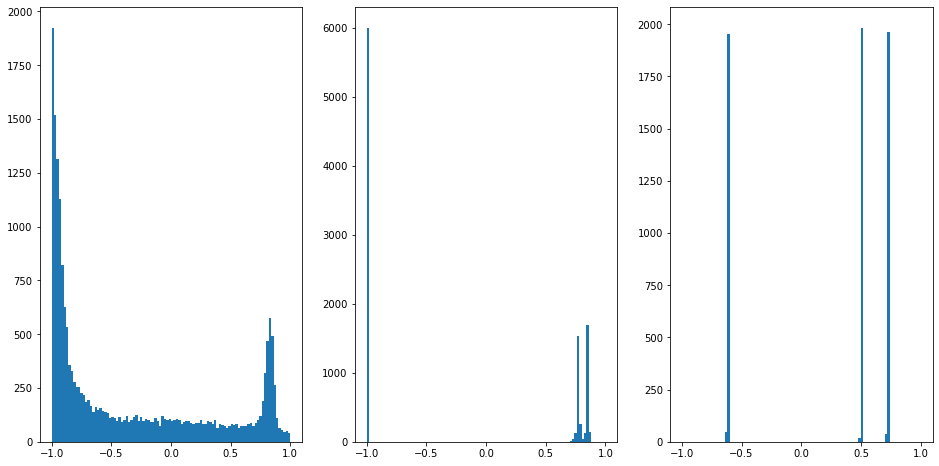

In [118]:
i=1
plt.figure(figsize=(16,8))
for key in network.activation.keys():
    plt.subplot(1,3,i)
    i+=1
    plt.hist(network.activation[key].flatten(),100,range=(-1,1))
    print(network.activation[key])

### 신경망의 성능

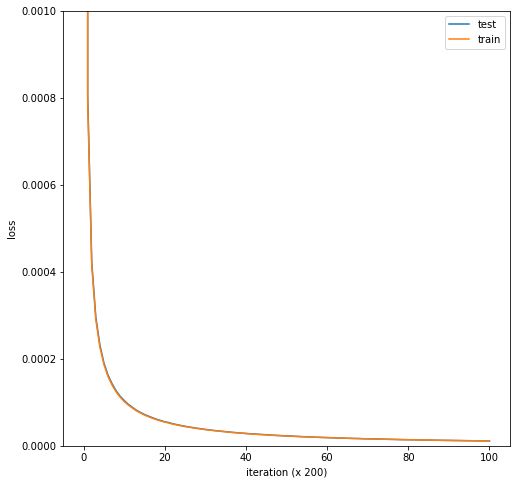

In [101]:
# loss 그래프 그리기 - 약한 노이즈 추가 후 xavier

plt.figure(figsize=(8,8))
plt.plot(range(len(test_acc_list)),test_acc_list, label='test')
plt.plot(range(len(train_acc_list)),train_acc_list, label='train')
plt.ylabel('loss')
plt.xlabel('iteration (x 200)')
plt.ylim(0,0.001)
plt.legend()

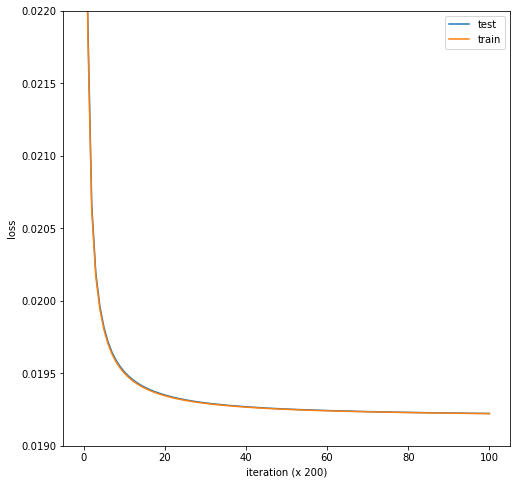

In [114]:
# loss 그래프 그리기 - 강한 노이즈 추가 후 xavier

plt.figure(figsize=(8,8))
plt.plot(range(len(test_acc_list)),test_acc_list, label='test')
plt.plot(range(len(train_acc_list)),train_acc_list, label='train')
plt.ylabel('loss')
plt.xlabel('iteration (x 200)')
plt.ylim(0.019,0.022)
plt.legend()

### 다양한 방식을 이용하여 가중치 초기화시 활성화값의 분포 

(array([2000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0., 2000.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 2000.]),
 array([-0.02373151, -0.02110775, -0.01848399, -0.01586023, -0.01323647,
        -0.0106127 , -0.00798894, -0.00536518, -0.00274142, -0.00011766,
         0.0025061 ,  0.00512986,  0.00775362,  0.01037739,  0.01300115,
         0.01562491,  0.01824867,  0.02087243,  0.02349619,  0.02611995,
         0.02874372,  0.03136748,  0.03399124,  0.036615  ,  0.03923876,
         0.04186252,  0.04448628,  0.04711005,  0.04973381,  0.05235757,
         0.05498133]),
 <BarContainer object of 30 artists>)

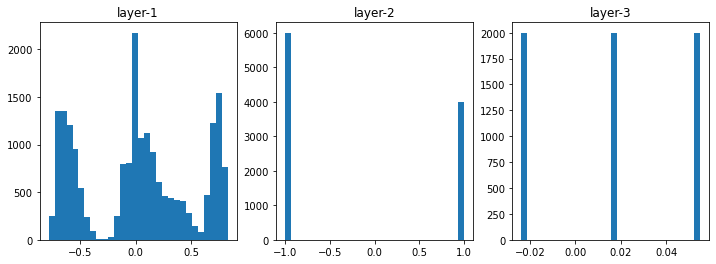

In [46]:
# std=0.01

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('layer-1')
plt.hist(network.activation[-3].flatten(),30)

plt.subplot(1,3,2)
plt.title('layer-2')
plt.hist(network.activation[-2].flatten(),30)

plt.subplot(1,3,3)
plt.title('layer-3')
plt.hist(network.activation[-1].flatten(),30)

(array([2000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0., 2000.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 2000.]),
 array([-0.40227253, -0.37325457, -0.3442366 , -0.31521863, -0.28620067,
        -0.2571827 , -0.22816473, -0.19914677, -0.1701288 , -0.14111083,
        -0.11209287, -0.0830749 , -0.05405694, -0.02503897,  0.003979  ,
         0.03299696,  0.06201493,  0.0910329 ,  0.12005086,  0.14906883,
         0.1780868 ,  0.20710476,  0.23612273,  0.2651407 ,  0.29415866,
         0.32317663,  0.3521946 ,  0.38121256,  0.41023053,  0.4392485 ,
         0.46826646]),
 <BarContainer object of 30 artists>)

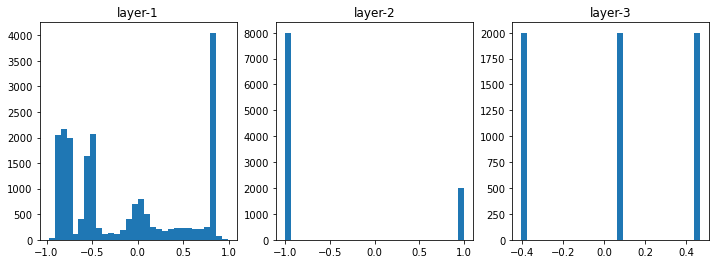

In [44]:
# std=0.1

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('layer-1')
plt.hist(network.activation[-3].flatten(),30)

plt.subplot(1,3,2)
plt.title('layer-2')
plt.hist(network.activation[-2].flatten(),30)

plt.subplot(1,3,3)
plt.title('layer-3')
plt.hist(network.activation[-1].flatten(),30)

(array([2000., 2000.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 2000.]),
 array([-0.61190816, -0.55849809, -0.50508802, -0.45167794, -0.39826787,
        -0.34485779, -0.29144772, -0.23803765, -0.18462757, -0.1312175 ,
        -0.07780742, -0.02439735,  0.02901272,  0.0824228 ,  0.13583287,
         0.18924294,  0.24265302,  0.29606309,  0.34947317,  0.40288324,
         0.45629331,  0.50970339,  0.56311346,  0.61652354,  0.66993361,
         0.72334368,  0.77675376,  0.83016383,  0.8835739 ,  0.93698398,
         0.99039405]),
 <BarContainer object of 30 artists>)

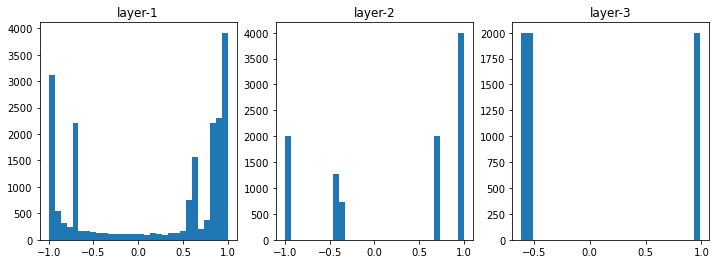

In [40]:
# std=1

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('layer-1')
plt.hist(network.activation[-3].flatten(),30)

plt.subplot(1,3,2)
plt.title('layer-2')
plt.hist(network.activation[-2].flatten(),30)

plt.subplot(1,3,3)
plt.title('layer-3')
plt.hist(network.activation[-1].flatten(),30)

(array([2000.,    0.,    0.,    0., 2000.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 2000.]),
 array([-0.4377569 , -0.39867806, -0.35959923, -0.3205204 , -0.28144157,
        -0.24236274, -0.20328391, -0.16420508, -0.12512625, -0.08604742,
        -0.04696859, -0.00788976,  0.03118907,  0.0702679 ,  0.10934673,
         0.14842556,  0.18750439,  0.22658322,  0.26566205,  0.30474088,
         0.34381971,  0.38289854,  0.42197737,  0.46105621,  0.50013504,
         0.53921387,  0.5782927 ,  0.61737153,  0.65645036,  0.69552919,
         0.73460802]),
 <BarContainer object of 30 artists>)

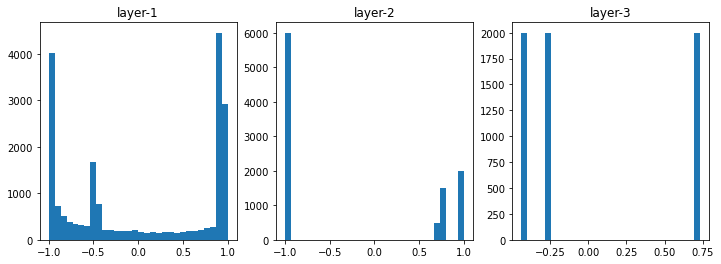

In [51]:
# Xavier

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('layer-1')
plt.hist(network.activation[-3].flatten(),30)

plt.subplot(1,3,2)
plt.title('layer-2')
plt.hist(network.activation[-2].flatten(),30)

plt.subplot(1,3,3)
plt.title('layer-3')
plt.hist(network.activation[-1].flatten(),30)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,  211., 3789.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0., 2000.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

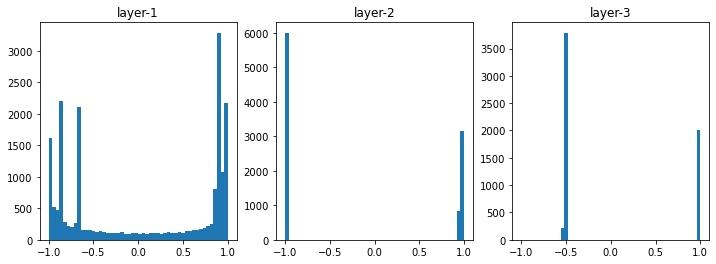

In [80]:
# Xavier - 노이즈 추가 후

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('layer-1')
plt.hist(network.activation[-3].flatten(),50,range=(-1,1))

plt.subplot(1,3,2)
plt.title('layer-2')
plt.hist(network.activation[-2].flatten(),50,range=(-1,1))

plt.subplot(1,3,3)
plt.title('layer-3')
plt.hist(network.activation[-1].flatten(),50,range=(-1,1))

### 두번째, 세번째 층 활성화 값의 분포가 극단적을 치우쳐져 있다

활성화 값의 분포가 치우쳐 져있다는 것은 해당층이 데이터 학습에 영향을 적게 미치고 있음을 의미한다. 하지만 loss를 보면 낮게 나오므로 신경망의 성능은 나쁘지 않다. 따라서 첫번째 층만 있어도 적절한 추론을 할수 있을 것이라고 예상할수 있다.

input, output형식은 유지하여 단층 퍼셉트론으로 1차식의 계수를 적절히 추정할 수 있는지 확인해보자. 

layer 사이에 들어가는 활성화 함수가 사라지고, 출력시에도 별다른 처리과정이 사라진다.



## 단층 퍼셉트론을 이용한 1차식의 계수 추정

In [34]:
from collections import OrderedDict
from scratch.common.gradient import numerical_gradient

class Perceptron:
    def __init__(self, i, o, weight_init_std=0.1):
        
        # 각층에서 사용할 매개변수를 초기화 
        # weight_init_std는 rand를 조절하는 역할을 함.
        self.params={}
        self.params['W1']= np.random.randn(i,o) * weight_init_std        
        self.params['b1']= np.zeros(o)
        
        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.lastLayer = Loss() # predict와 loss 계산을 분리 하기 위해
        
    # 각 계층을 forward이동     
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x # (label 종류, )
        
        
    def loss(self, x, t):
        y = self.predict(x)
        
        # 신경망의 예상값 y 와 정답 t 비교
        return self.lastLayer.forward(y,t)
        
    
    # 결과값 비교를 위한 수치미분
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t) # numerical_gradient가 loss 함수와 계산하려는 x를 입력받음
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W , self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W , self.params['b1'])
        
        return grads # loss를 각계층의 매개변수로 편미분 한 값
        
    def gradient(self, x, t):
        
        # 순전파 - 역전파시 순전파때 나오는 값을 사용하는 경우도 있으므로 순전파가 선행되어야 함
        self.loss(x, t)
        
        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        
        for layer in layers:
            dout = layer.backward(dout)
            # print(f'역전파 {layer}',dout.shape)
            # 모든 layer를 지나고 나면 dW, db를 구해 각 측에 저장됨
        
        # 역전파로 각 층에 저장된 gradient모으기
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        
        return grads

In [23]:
network = Perceptron(2,3)

x_batch= x_train[:3]
t_batch= t_train[:3]


grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key,diff)

W1 4.4875330303580557e-13
b1 6.602866401787347e-13


In [ ]:
perceptron = Perceptron(2,3)

iteration = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

train_loss_list=[]
test_loss_list=[]

iter_per_epoch = max(train_size/batch_size, 1)

for i in range(iteration):
    # mini batch생성
    batch_mask = np.random.choice(train_size, batch_size) # 무작위로 100개의 데이터 선택
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # gradient구하기 (오차 역전파법)
    grad = perceptron.gradient(x_batch, t_batch)

    # parameter update
    for key in ('W1','b1'):
        perceptron.params[key] -= learning_rate * grad[key]

    # 업데이트된 parameter로 loss 계산
    loss = perceptron.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    print(i,loss)
    
    if i%iter_per_epoch==0 or i==(iteration-1):
        # 전체 데이터를 학습에 사용하고 나면 전체 데이터에 대한 정확도 계산
        loss = perceptron.loss(x_test, t_test)
        test_loss_list.append(loss)
        #print(i,':',loss)
    

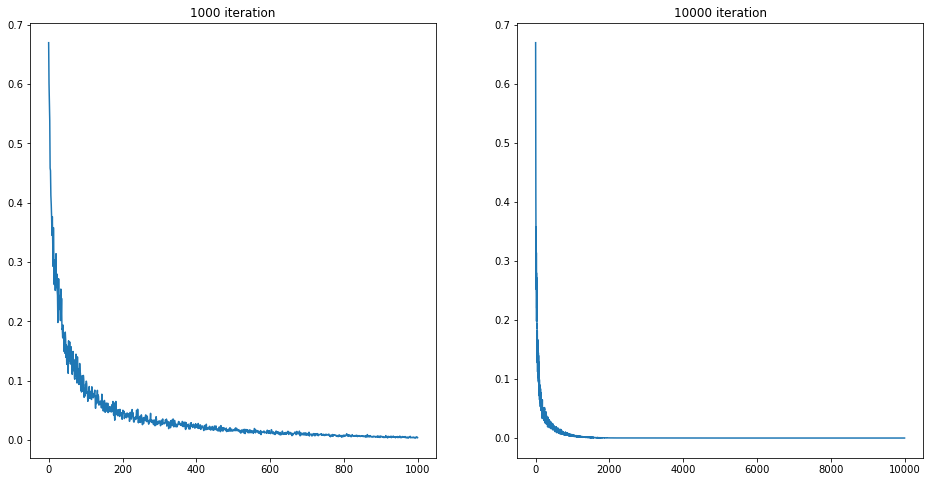

In [45]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.title('1000 iteration')
plt.plot(range(0,1000), train_loss_list[:1000])

plt.subplot(1,2,2)
plt.title('10000 iteration')
plt.plot(range(0,10000), train_loss_list)

망의 층이 줄어들고 활성화 함수도 사라지는 등 단순해 졌지만 loss는 작고, 안정적으로 학습된다. 

In [43]:
perceptron.predict(x_test[1])

array([-0.69999992,  0.49999993,  0.89999988])

In [40]:
network.predict(x_test[1])

array([-0.69937115,  0.50078042,  0.90065132])

In [30]:
answer

[-0.7, 0.5, 0.9]

## 입력과 출력형식을 바꿔보자!

이전에 만든 망은 입력으로 x,y좌표를 받고, x+by+c=0의 계수를 출력했다. 이번에는 x좌표를 입력하면 y좌표를 출력하도록 설계해보자.

In [50]:
perceptron = Perceptron(1,1)

# y = Wx +b

w = np.random.randn(1)
b = np.zeros(1)

x_train = x_data[:8000]
y_train = y_data[:8000]

x_test = x_data[8000:]
y_test = y_data[8000:]

learning_rate = 0.01
iteration = 10000
train_size = len(x_train)
batch_size = 100

train_loss_list=[]
test_loss_list=[]

iter_per_epoch = max(train_size/batch_size, 1)

for i in range(iteration):
    # mini batch생성
    batch_mask = np.random.choice(train_size, batch_size) # 무작위로 100개의 데이터 선택
    x_batch = x_train[batch_mask]
    t_batch = y_train[batch_mask]

    # gradient구하기 (오차 역전파법)
    grad = perceptron.gradient(x_batch, t_batch)

    # parameter update
    for key in ('W1','b1'):
        perceptron.params[key] -= learning_rate * grad[key]

    # 업데이트된 parameter로 loss 계산
    loss = perceptron.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    print(i,loss)
    
    if i%iter_per_epoch==0 or i==(iteration-1):
        # 전체 데이터를 학습에 사용하고 나면 전체 데이터에 대한 정확도 계산
        loss = perceptron.loss(x_test, y_test)
        test_loss_list.append(loss)
        print('epoch',i,':',loss)
    



0 329.7818635316044
epoch 0 : 6111.749765636761
1 243.0698708371964
2 273.9172011786098
3 366.5157357988428
4 291.89254379118825
5 247.73662850927596
6 250.61588071455043
7 257.9138852001671
8 238.4530938380507
9 228.1794452597725
10 266.2190820756441
11 208.73254209016454
12 306.21830342707517
13 217.39651674087156
14 211.28163705329368
15 219.9002126075609
16 221.34092958555541
17 289.12265062743205
18 222.5054249167702
19 257.84910787695037
20 197.7195257506352
21 252.91119134482565
22 219.2670769698801
23 220.705443489011
24 242.07378740241543
25 192.54104838191103
26 178.77343873068764
27 188.18763666131997
28 193.55334823946
29 208.27951117531995
30 220.26382311782123
31 198.11987013247992
32 242.05791540390118
33 168.10109461394424
34 216.7461635588021
35 150.2424765760313
36 170.59128795772824
37 164.03015778654813
38 163.98020243659042
39 142.30803558256906
40 150.9799014259362
41 146.80481801607522
42 164.68661238564073
43 129.30101866003403
44 150.54271221591895
45 146.12486

387 47.452121780439796
388 53.3115047555752
389 55.34997314608003
390 57.64237413425429
391 48.87198129873807
392 42.66179886273124
393 42.30137850182259
394 51.59983718523508
395 57.62758105825638
396 44.982362770302444
397 44.84637128896018
398 53.04652823550047
399 34.815741855303216
400 43.61245752818895
epoch 400 : 986.2474697598041
401 48.4861693548092
402 43.56401980595074
403 42.93868688570686
404 43.709569057511565
405 41.55254222352555
406 54.11558968241245
407 50.71126270764439
408 70.14460403112629
409 46.45333490192571
410 57.53790485598555
411 51.16207379749182
412 51.72588912795838
413 65.48928120039145
414 48.830751068577165
415 44.013627900021575
416 48.68489308261819
417 51.582459739824124
418 52.74245856869313
419 52.85165923868362
420 64.21722923636649
421 41.7410528813229
422 51.43192603418691
423 56.648825764573736
424 61.647449358843154
425 62.98961087127089
426 52.9381012324716
427 49.46513307719959
428 47.631583619068266
429 45.37314632661569
430 55.70930944838

1012 61.793055081284265
1013 47.834794293355685
1014 54.375625025019495
1015 43.91807262490659
1016 56.75298903187111
1017 39.27066460371528
1018 46.4628107342599
1019 64.41660248788295
1020 65.28468199752747
1021 61.20288103540412
1022 48.399883736719715
1023 36.82440433138261
1024 50.68806555610565
1025 51.55766453172242
1026 50.87512052499209
1027 39.47789492046046
1028 47.655175843525015
1029 49.3987281476739
1030 52.70251333560347
1031 56.300237799238694
1032 42.463420888636534
1033 45.48093324161126
1034 46.95899271050736
1035 53.06837645577078
1036 43.35133604768447
1037 42.764154017783554
1038 46.77438024369961
1039 49.37335366385075
1040 45.59178563294591
epoch 1040 : 980.0623722748464
1041 46.22847763999233
1042 42.72332589392921
1043 54.38567890241526
1044 55.53590499622628
1045 40.82905215529467
1046 44.10938402876417
1047 43.85703230430528
1048 52.181855648191785
1049 45.71839876119442
1050 67.6885063382439
1051 55.114064144930964
1052 48.318999768475685
1053 48.3744648989

1661 51.07335783252945
1662 47.577371040830094
1663 47.66851978611308
1664 59.56923182727633
1665 54.89370188454149
1666 44.54751921478983
1667 35.622956870385615
1668 48.72771807761224
1669 53.20237391855046
1670 41.86155044488185
1671 42.803845143677286
1672 65.96535573730611
1673 49.23650124413112
1674 48.81401471151322
1675 40.74084865681491
1676 59.80530065463676
1677 52.108459971529165
1678 59.18347591300902
1679 42.01666279692539
1680 47.594650842094815
epoch 1680 : 980.1135499994606
1681 46.29418919722955
1682 39.89800966160187
1683 47.70423303062059
1684 55.305484750783414
1685 49.69333401456048
1686 48.478174937139514
1687 36.52677798844119
1688 44.2468320002005
1689 43.11702804600227
1690 41.24886308976683
1691 41.24827847651998
1692 59.57013094008197
1693 61.91287515509062
1694 59.80426042787136
1695 54.34089443243061
1696 60.6287080154603
1697 66.96570189828633
1698 41.62194923396537
1699 54.789219065155784
1700 47.74155285589618
1701 62.345533884235984
1702 46.36423634638

2321 49.47556549979502
2322 43.429416407377246
2323 56.423945858569425
2324 52.40875655902181
2325 59.73061000121484
2326 53.53726408868967
2327 49.17217157301241
2328 53.31744574611062
2329 47.60817863332692
2330 57.74245994256479
2331 47.95324108653377
2332 66.26510554773922
2333 54.716356694629674
2334 49.58498964213535
2335 58.479018848878596
2336 59.61670551618293
2337 52.487751628237106
2338 45.91930089457236
2339 61.09256163285791
2340 53.77858082408328
2341 48.47502145993488
2342 43.230321883372675
2343 43.98569799620517
2344 60.182921818991474
2345 46.765811416341805
2346 51.32753221692401
2347 55.97561239029977
2348 49.477052555596494
2349 57.65552222997317
2350 42.48269643507832
2351 35.40252457204364
2352 45.75698740021148
2353 48.16614136890646
2354 55.40418072984791
2355 51.214594386967235
2356 46.58171614415071
2357 42.8093162748657
2358 52.050223574321755
2359 54.00860174873109
2360 40.620329588048925
2361 59.130993998147595
2362 49.714738368027696
2363 48.9635984916390

2976 50.33826273300078
2977 51.699098364538116
2978 44.48766487077859
2979 54.923190361028134
2980 59.756904263361825
2981 48.13589626348701
2982 48.045477239458016
2983 46.88057391162428
2984 53.18301826033359
2985 34.513774996096146
2986 40.90925958904647
2987 55.33002166262263
2988 55.84825688183745
2989 43.836203538211166
2990 56.014138865548524
2991 44.312205737263106
2992 59.92889194860995
2993 51.710756581411104
2994 50.244565598822106
2995 63.482739428505845
2996 41.58692773942217
2997 58.75420024142672
2998 49.90455716167942
2999 54.68800259550713
3000 66.16440326645571
3001 52.74934179475036
3002 54.88175420635922
3003 59.188060298914216
3004 40.55544726598887
3005 40.63562214327673
3006 47.25714056836163
3007 47.911010489339965
3008 40.6812325353788
3009 59.011971783472
3010 58.1020391187518
3011 54.7395435821803
3012 50.291385234206516
3013 42.93396989489476
3014 51.918087552094995
3015 58.03687904067953
3016 61.76064645238845
3017 54.09605207362473
3018 52.95960425835856
3

3434 52.5559803514772
3435 46.004150051281755
3436 36.39800470521277
3437 60.93110829250912
3438 56.09198654853643
3439 47.889633678494505
3440 46.89616336285734
epoch 3440 : 980.8118041248456
3441 50.29574328529156
3442 56.2406128947259
3443 46.451222809273844
3444 52.82113539719213
3445 46.56567810922634
3446 58.330865162374
3447 43.78870823088896
3448 59.76164682850471
3449 40.1208480271659
3450 46.173138366413596
3451 48.511669971922124
3452 58.78101613224483
3453 42.980600616170754
3454 39.95960448468696
3455 50.13162196862252
3456 46.85502961057674
3457 41.01323209683197
3458 53.308830712221436
3459 58.70551248218699
3460 45.882339106428454
3461 55.15077020915756
3462 47.24496200732505
3463 58.12815844388423
3464 49.22936698990535
3465 51.53720081977656
3466 46.234784620740776
3467 35.42930062519385
3468 43.84290008208831
3469 47.40330668719128
3470 53.65495322166286
3471 45.895609977347625
3472 54.077820574979086
3473 51.83157087646535
3474 55.249365974445425
3475 45.92095081599

3934 46.207847480545695
3935 44.734775130812544
3936 56.50886460561747
3937 53.27732086656225
3938 59.780875611300154
3939 56.1064690379112
3940 54.08825345661738
3941 59.13199192929488
3942 43.983021789738196
3943 56.57218669212769
3944 38.20461455955093
3945 65.86634158868426
3946 43.663894163916154
3947 43.56489554413727
3948 38.492104054630644
3949 52.38593351444257
3950 51.35914933866954
3951 41.807414298516875
3952 53.321525473287764
3953 52.625035393335025
3954 45.35511561483094
3955 52.41860726862221
3956 45.47346603408361
3957 54.055562526817276
3958 48.16313707769926
3959 50.22855674049583
3960 48.810935608919415
3961 61.06391321865241
3962 45.27150533357507
3963 49.015230259306435
3964 53.09829704443044
3965 58.88686219732852
3966 53.20266784134642
3967 40.808597868009514
3968 55.94486082518475
3969 57.6630894466728
3970 38.732594765551966
3971 40.797224543686056
3972 55.916374153216694
3973 45.01499057792876
3974 54.65592662539787
3975 41.72608075455953
3976 51.275259204398

4421 47.651864477171316
4422 47.81739291110589
4423 47.62849897054787
4424 45.10047488491081
4425 57.18097745204758
4426 57.3754840013555
4427 45.22381195389376
4428 53.214263617733465
4429 47.62422686664691
4430 57.06357108053822
4431 56.406638729999855
4432 51.344853612478495
4433 49.83922615418652
4434 50.05597076648681
4435 61.75171719793689
4436 60.79501501982351
4437 51.38794195765589
4438 42.48180297807874
4439 51.172767082002366
4440 43.31445290507238
4441 47.918460831095075
4442 55.83588805184767
4443 52.06225171411903
4444 52.89132117660521
4445 53.79611688707156
4446 45.636303780997864
4447 40.28185751003044
4448 54.91983638105415
4449 50.32249463842938
4450 57.132202215080056
4451 56.00844075255284
4452 54.05470436051381
4453 51.8468053947584
4454 66.56127934411555
4455 53.12533035912655
4456 42.422308516478004
4457 49.17824222778363
4458 58.63882636255763
4459 48.1566799666345
4460 56.820715601915346
4461 37.60430304594106
4462 51.199821963135136
4463 49.840514169712
4464 

4837 36.220758397111084
4838 52.53791774963214
4839 44.77741525888527
4840 57.85690244029098
4841 62.490843542072845
4842 59.45850597268477
4843 42.755693323528185
4844 49.1594636977147
4845 50.56694402433444
4846 47.58253793152322
4847 42.15897084960952
4848 35.79555523047275
4849 45.8283964791913
4850 62.414837204532276
4851 40.14778262684871
4852 59.23847669713789
4853 54.55970587647779
4854 49.94819181270718
4855 42.31986018995405
4856 48.04384288120162
4857 45.533664906748626
4858 48.62864727570404
4859 45.50364489442841
4860 64.36585919182171
4861 40.8898008345339
4862 45.72170575852084
4863 45.876736724829684
4864 58.537380285289856
4865 39.15051122147023
4866 56.554004978118094
4867 41.448789289348845
4868 51.84878750076594
4869 55.28369773213778
4870 41.306398489203694
4871 45.08743207922902
4872 58.31089817881258
4873 49.39642398569388
4874 48.20653390305639
4875 69.9801081949321
4876 44.592670837096655
4877 62.42687372791179
4878 54.16319204590416
4879 45.057494493585295
488

5226 54.306244553556866
5227 50.153168087722264
5228 45.41324334471669
5229 60.648428700831005
5230 64.8602818119828
5231 43.65337693073227
5232 47.6554972827371
5233 42.45742388415136
5234 43.53025138931579
5235 45.930253978526835
5236 61.70035921648488
5237 52.37032276189576
5238 46.478435920806724
5239 40.67673818768113
5240 43.55754435429768
5241 49.06175403429002
5242 54.887646708983546
5243 54.153651881401494
5244 51.82118870015621
5245 48.23668835204392
5246 42.574364236381996
5247 46.69059087633785
5248 53.076243492455546
5249 52.16261892495974
5250 48.477282166450806
5251 46.298993318644705
5252 47.2091244337244
5253 40.71509871598771
5254 52.779165468448504
5255 57.37432749623991
5256 51.65374487322919
5257 54.23038652507186
5258 48.425147379118066
5259 47.51711959597641
5260 51.86419313913874
5261 62.48344341729431
5262 48.36955379802645
5263 42.811392029236465
5264 54.367410611797894
5265 44.0996169256437
5266 47.0965128124111
5267 57.49414433076973
5268 56.610968484935455


6000 50.910486177378836
epoch 6000 : 979.3238640947027
6001 54.4075300636767
6002 52.43733901631878
6003 51.27746419156657
6004 48.12338390652922
6005 41.18530254563278
6006 53.494547278668975
6007 39.67891512478814
6008 54.21105348546183
6009 45.356258940381764
6010 45.14565410822739
6011 55.44003116811767
6012 57.46221341025583
6013 61.55295267444652
6014 58.31264695044676
6015 55.0790544276392
6016 39.02848745727915
6017 36.0293522991666
6018 50.0953655958462
6019 54.06254577260603
6020 49.37325950666007
6021 45.01751584649544
6022 41.66410082033993
6023 52.540076510894544
6024 46.26316424416633
6025 49.32099631393967
6026 45.596735236085316
6027 61.24496431484536
6028 46.304543843948295
6029 44.864003417695315
6030 45.39135402422023
6031 58.14721040307159
6032 39.884091568032446
6033 39.621959236634865
6034 57.11683238251057
6035 55.8538940574623
6036 38.73380498908197
6037 35.81417323940411
6038 45.7232113559225
6039 51.735238780752816
6040 40.84521560169314
6041 61.3978002517516


6544 45.85655701287837
6545 40.43655785827466
6546 47.71828816088106
6547 55.449164908133106
6548 42.98699909652785
6549 52.11037055966653
6550 61.05164126318088
6551 48.42469433610582
6552 56.13846613320721
6553 45.5686912453906
6554 39.92313170977244
6555 40.18638508123361
6556 40.779034430119104
6557 52.48038010401696
6558 54.458810633173954
6559 61.06155434862619
6560 42.08948800950262
epoch 6560 : 979.3381479205217
6561 59.76858357897214
6562 51.54313550611336
6563 50.72809833863844
6564 40.47454331358081
6565 48.423302351305786
6566 43.41127349818738
6567 42.822585689217924
6568 66.42812357499083
6569 53.81606443734847
6570 52.275100051522294
6571 60.95199316078764
6572 54.653998189435484
6573 51.22748384756811
6574 44.680076545500526
6575 63.315869580034686
6576 46.37724647148232
6577 56.48445769788572
6578 44.51329713429801
6579 40.88860132252634
6580 60.64366932429847
6581 52.5577599752524
6582 49.5291669825525
6583 67.10999277719206
6584 54.46996546534191
6585 63.671447868621

7033 32.166991316688616
7034 52.824561961180954
7035 56.025150890805065
7036 43.2428761796708
7037 59.62659015636605
7038 48.15852297928767
7039 46.6725975847311
7040 43.34831130506802
epoch 7040 : 981.3867279957856
7041 55.16633169065244
7042 36.407510280162185
7043 46.95256178426924
7044 60.32473507551793
7045 36.870079275049186
7046 49.25431710569426
7047 60.56468219212697
7048 42.097549168393925
7049 50.27793065763776
7050 60.828277471816826
7051 44.30574621678188
7052 46.30345459299258
7053 50.4474300256292
7054 42.57764942328135
7055 39.79818626466567
7056 53.56651745752025
7057 51.37599347745722
7058 45.29734028276016
7059 48.41130661219584
7060 41.01024203239689
7061 42.01344364279619
7062 53.072557246038855
7063 64.4763404972132
7064 50.416440421460685
7065 41.42031908799328
7066 50.76801028240855
7067 55.7089997106884
7068 54.01652346269889
7069 45.76249080979451
7070 54.41010246021503
7071 53.5734896433443
7072 58.829221462097784
7073 51.92118212551724
7074 54.17077775970865

7508 45.867310665678964
7509 49.60606529225143
7510 54.4276084829106
7511 53.96706445971934
7512 47.039474907736164
7513 44.23130490436099
7514 50.8281465093849
7515 49.923878066903384
7516 73.75423510156222
7517 36.948971427151854
7518 51.96835317204489
7519 48.51577255372594
7520 55.644468726197374
epoch 7520 : 980.4324651446
7521 46.445603131017265
7522 55.9919690731386
7523 78.52606392845458
7524 37.44571921559079
7525 73.689615286258
7526 42.16759296112966
7527 44.15248162714588
7528 55.89981661950151
7529 69.01893522517597
7530 50.46846179371963
7531 68.0314985823526
7532 51.90406818544331
7533 43.00157776126054
7534 52.38844420748894
7535 51.52342430657319
7536 52.44830619566611
7537 44.34640456405249
7538 51.43686193265331
7539 52.123558867709555
7540 46.64037671559739
7541 52.37685492712447
7542 57.14239775760339
7543 50.795578150624614
7544 46.46757181316698
7545 64.38674452646566
7546 34.652939799789856
7547 57.63730532626027
7548 42.204917221080194
7549 47.222668378541265
7

7990 43.16448947918478
7991 55.90866655012399
7992 41.75316527393869
7993 64.18187215053828
7994 45.717733160970354
7995 57.7866208085475
7996 46.28951626768273
7997 57.684730305963626
7998 53.658079488810316
7999 45.123219618071964
8000 43.9010410562567
epoch 8000 : 978.9565122482529
8001 53.052577959322825
8002 38.82337895014306
8003 51.666848988631365
8004 40.70535034288967
8005 60.79678302822714
8006 48.71954291194574
8007 55.42126622991516
8008 43.978862706547176
8009 42.773209483770955
8010 43.55826349890402
8011 58.554110841954156
8012 54.36987405765094
8013 59.3716634860267
8014 56.53512932328601
8015 36.77796832271378
8016 64.48868131112756
8017 44.48028253724321
8018 54.797778674723446
8019 49.1441512536028
8020 62.17513381567403
8021 52.30821284792239
8022 44.49048526118871
8023 59.90165488182416
8024 56.28155496441815
8025 47.182014143442714
8026 45.2550794316296
8027 48.27178443366691
8028 48.44905198153524
8029 60.56859433220712
8030 56.47039732703185
8031 51.801936119515

8372 48.39404888668436
8373 55.940917103078434
8374 55.2898499422219
8375 56.50500992863257
8376 47.84370634518024
8377 56.292177266805346
8378 45.86997550579732
8379 51.362255689826114
8380 54.04164441803046
8381 56.65602689268813
8382 47.77454414357096
8383 52.12468961462984
8384 53.65700468596774
8385 48.02403991105819
8386 53.64515063824306
8387 52.80960414850702
8388 59.29901474286797
8389 61.88592184948483
8390 42.89411281694242
8391 41.85190512349933
8392 45.80533588739222
8393 50.65163928298269
8394 47.30875685211608
8395 51.2873811150223
8396 47.87132429987283
8397 52.079495810362296
8398 49.6288122107513
8399 62.46430509925667
8400 46.23342291087251
epoch 8400 : 980.438433085591
8401 53.86244321636013
8402 50.82627455665718
8403 52.96102740123611
8404 45.12744744311404
8405 55.05293202298474
8406 54.67331632551275
8407 56.8500064120469
8408 51.45168234554252
8409 37.67401302645401
8410 42.59578513816053
8411 51.21571519843982
8412 43.297895199586726
8413 46.680081976898336
84

8820 41.91821845372772
8821 55.285596186066755
8822 47.617935381110115
8823 47.67681550103336
8824 63.84600917691232
8825 56.74987039635504
8826 48.63570490781533
8827 42.590208874186295
8828 57.626052452512404
8829 50.36892803221087
8830 41.43010678877568
8831 44.61770414055535
8832 50.87343958982306
8833 48.760565067280986
8834 37.39656627968908
8835 47.805560380741795
8836 60.44445700619635
8837 45.787305248351984
8838 51.99042786224056
8839 47.27142399377803
8840 53.817548212859776
8841 37.64167973365617
8842 49.37010363103249
8843 60.00030102478112
8844 53.30738907044107
8845 47.80325819629246
8846 45.37690380718918
8847 45.80408950238916
8848 42.03471265285676
8849 41.508003869928395
8850 65.65793145089152
8851 48.45102358226927
8852 52.78251520903764
8853 55.41980219122585
8854 50.087156393318445
8855 57.41102449698288
8856 54.15907498085513
8857 45.391090375646414
8858 52.96633740620156
8859 59.80893777938673
8860 59.96901231663542
8861 47.42493390494728
8862 50.367107415127094

9445 52.89602895631362
9446 65.729776613432
9447 56.668633315492826
9448 49.947466510052166
9449 49.54729477630193
9450 53.33305071969731
9451 53.739475185761854
9452 56.860417582619114
9453 48.88725996507532
9454 59.063677981079714
9455 48.328341010408515
9456 50.32575097228808
9457 48.34262195920989
9458 45.32832643098389
9459 44.876959380346854
9460 43.70488470509407
9461 45.47651406364816
9462 46.051080855888344
9463 44.036966532012244
9464 48.714220484647576
9465 49.0423620426678
9466 54.638534781040065
9467 50.1189440210243
9468 48.783817651143906
9469 50.77501890469509
9470 44.60997893592279
9471 69.25193343191067
9472 41.71438892658664
9473 51.00294239715686
9474 53.240976093939764
9475 53.07409789923944
9476 54.10726086506049
9477 46.224337408590834
9478 49.56100290963516
9479 46.1194775894741
9480 49.203780377081124
9481 52.3044018712721
9482 42.92117149471299
9483 41.59637181814887
9484 45.526828103933134
9485 52.683294305658784
9486 60.78516878783871
9487 50.50591267099645


9982 48.37661881301163
9983 46.05040087953785
9984 44.16099660960946
9985 42.545349261593685
9986 52.190256047228246
9987 45.3110943374647
9988 40.624122861416616
9989 50.40422517652312
9990 55.8167491296472
9991 47.667392330418174
9992 59.0009548167194
9993 54.77152524274845
9994 50.42794308750228
9995 64.84874162278965
9996 44.95466017815212
9997 54.904363073656334
9998 46.241558479684564
9999 45.318218013431284
epoch 9999 : 979.5778331938129


In [64]:
x=2

In [65]:
perceptron.predict(x)

array([[1.04878717]])

In [66]:
y_answer = (- c - a * x)/b
print(y_answer)

0.9999999999999998
